In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [31]:
data = pd.read_csv('PSP_Jan_Feb_2019.csv')

In [32]:
data['tmsp'] = pd.to_datetime(data['tmsp'])

In [33]:
from sklearn.model_selection import train_test_split

X = data # Features
y = data['PSP']  # Target variable

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Display the shapes of the datasets to verify the split
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (35287, 7), (35287,)
Validation set shape: (13610, 7), (13610,)
Test set shape: (1513, 7), (1513,)


In [34]:
X_train.shape, X_test.shape

((35287, 7), (1513, 7))

In [35]:
success_rate = X_train.groupby(['country', 'card'])['success'].mean().reset_index()
success_rate.rename(columns={'success': 'country_card_success_rate'}, inplace=True)
X_train = X_train.merge(success_rate, on=['country', 'card'], how='left')

# success_rate = X_val.groupby(['country', 'card'])['success'].mean().reset_index()
# success_rate.rename(columns={'success': 'success_rate'}, inplace=True)
# X_val = X_val.merge(success_rate, on=['country', 'card'], how='left')

# success_rate = X_test.groupby(['country', 'card'])['success'].mean().reset_index()
# success_rate.rename(columns={'success': 'success_rate'}, inplace=True)
# X_test = X_test.merge(success_rate, on=['country', 'card'], how='left')


In [36]:
from math import ceil
# Create a new feature 'week_of_month' to extract the week number of the month from the timestamp
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

X_train['week_of_month'] = X_train['tmsp'].apply(week_of_month)

In [37]:
X_train['hour'] = X_train['tmsp'].dt.hour

In [38]:
# Create a new feature 'transaction_hour' to categorize transactions into different time periods of the day
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

X_train['transaction_hour'] = X_train['hour'].apply(categorize_hour)

# Create a new feature 'amount_category' to categorize transaction amounts into different ranges
def categorize_amount(amount):
    if amount < 133:
        return 'Low'
    elif 133 <= amount < 201:
        return 'Medium'
    else:
        return 'High'

X_train['amount_category'] = X_train['amount'].apply(categorize_amount)

In [39]:
X_train['weekday'] = X_train['tmsp'].dt.day_name()
# data.head()

In [40]:
secured_success_rate = X_train.groupby(['country', 'card','3D_secured'])['success'].mean().reset_index()
secured_success_rate.rename(columns={'success': 'secured_success_rate_of_card'}, inplace=True)
X_train = X_train.merge(secured_success_rate, on=['country','card','3D_secured'], how='left')

In [41]:
X_train.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card',
       'country_card_success_rate', 'week_of_month', 'hour',
       'transaction_hour', 'amount_category', 'weekday',
       'secured_success_rate_of_card'],
      dtype='object')

In [42]:
# # Calculate the success rate with respect to the 3D secured column for each country
# secured_success_rate = X_train.groupby(['country', 'card','3D_secured'])['success'].mean().reset_index()

# # Rename the 'success' column to 'secured_success'
# secured_success_rate.rename(columns={'success': 'secured_success_rate_of_card'}, inplace=True)

# # Merge the secured_success_rate dataframe with the original data to add the secured_success feature
# X_train = X_train.merge(secured_success_rate, on=['country', 'card','3D_secured'], how='left')

In [43]:
# Calculate the success rate for each PSP grouped by country
country_psp_success_rate = X_train.groupby(['country', 'PSP'])['success'].mean().reset_index()

# Rename the 'success' column to 'country_psp_success_rate'
country_psp_success_rate.rename(columns={'success': 'country_psp_success_rate'}, inplace=True)

# Merge the country_psp_success_rate dataframe with the original data to add the country_psp_success_rate feature
X_train = X_train.merge(country_psp_success_rate, on=['country', 'PSP'], how='left')

In [44]:
# # Filter the data to get the success rate of UK_Card in Germany
# uk_card_germany_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Germany')]['success'].mean()

# # Add the success rate as a new column to the dataframe
# X_train['uk_card_germany_successrate'] = uk_card_germany_successrate

# Create a new feature 'uk_card_germany_successrate' based on the condition
uk_card_germany_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['uk_card_germany_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_autria_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['uk_card_austria_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Austria' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_swiz_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['uk_card_swiz_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'UK_Card' else 0, axis=1
)

simplecard_germany_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['simplecard_germany_successrate'] = X_train.apply(
    lambda row: simplecard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_autria_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['simplecard_austria_successrate'] = X_train.apply(
    lambda row: simplecard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_swiz_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['simplecard_swiz_successrate'] = data.apply(
    lambda row: simplecard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Simplecard' else 0, axis=1
)

moneycard_germany_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['moneycard_germany_successrate'] = X_train.apply(
    lambda row: moneycard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_autria_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['moneycard_austria_successrate'] = X_train.apply(
    lambda row: moneycard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_swiz_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['moneycard_swiz_successrate'] = X_train.apply(
    lambda row: moneycard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Moneycard' else 0, axis=1
)

goldcard_germany_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['goldcard_germany_successrate'] = X_train.apply(
    lambda row: goldcard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_autria_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['goldcard_austria_successrate'] = X_train.apply(
    lambda row: goldcard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_swiz_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['goldcard_swiz_successrate'] = X_train.apply(
    lambda row: goldcard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Goldcard' else 0, axis=1
)

In [45]:
X_train.shape, X_test.shape

((35287, 27), (1513, 7))

In [46]:
X_train.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card',
       'country_card_success_rate', 'week_of_month', 'hour',
       'transaction_hour', 'amount_category', 'weekday',
       'secured_success_rate_of_card', 'country_psp_success_rate',
       'uk_card_germany_successrate', 'uk_card_austria_successrate',
       'uk_card_swiz_successrate', 'simplecard_germany_successrate',
       'simplecard_austria_successrate', 'simplecard_swiz_successrate',
       'moneycard_germany_successrate', 'moneycard_austria_successrate',
       'moneycard_swiz_successrate', 'goldcard_germany_successrate',
       'goldcard_austria_successrate', 'goldcard_swiz_successrate'],
      dtype='object')

In [47]:
X_train.head()

,tmsp,country,amount,success,PSP,3D_secured,card,country_card_success_rate,week_of_month,hour,...,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_austria_successrate,moneycard_swiz_successrate,goldcard_germany_successrate,goldcard_austria_successrate,goldcard_swiz_successrate
0,2019-01-22 17:55:11,Austria,250,0,UK_Card,0,Visa,0.204069,4,17,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,2019-02-23 02:46:55,Germany,208,0,UK_Card,0,Master,0.195348,4,2,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,2019-02-08 08:55:57,Germany,149,0,Goldcard,0,Master,0.195348,2,8,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.396254,0.0,0.0
3,2019-02-05 16:55:35,Switzerland,129,0,UK_Card,0,Diners,0.217274,2,16,...,0.199084,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,2019-02-18 14:57:21,Germany,177,0,UK_Card,0,Master,0.195348,4,14,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [48]:
X_train.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card',
       'country_card_success_rate', 'week_of_month', 'hour',
       'transaction_hour', 'amount_category', 'weekday',
       'secured_success_rate_of_card', 'country_psp_success_rate',
       'uk_card_germany_successrate', 'uk_card_austria_successrate',
       'uk_card_swiz_successrate', 'simplecard_germany_successrate',
       'simplecard_austria_successrate', 'simplecard_swiz_successrate',
       'moneycard_germany_successrate', 'moneycard_austria_successrate',
       'moneycard_swiz_successrate', 'goldcard_germany_successrate',
       'goldcard_austria_successrate', 'goldcard_swiz_successrate'],
      dtype='object')

In [49]:
X_train[(X_train['country'] == 'Switzerland') & (X_train['card'] == 'Diners')]['country_card_success_rate'].value_counts()

country_card_success_rate
0.217274    1482
Name: count, dtype: int64

In [50]:
# country_card_success_rate = X_train.country_card_success_rate.unique()

In [51]:
def add_country_card_success_rate(df):
    # Loop through the dataframe
    for index, row in df.iterrows():
        # Check if the country is Germany and the card is Visa
        if row['country'] == 'Germany' and row['card'] == 'Visa':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.216914
        if row['country'] == 'Germany' and row['card'] == 'Master':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.195348
        if row['country'] == 'Germany' and row['card'] == 'Diners':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.226308

        if row['country'] == 'Austria' and row['card'] == 'Visa':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.204069
        if row['country'] == 'Austria' and row['card'] == 'Master':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.198462
        if row['country'] == 'Austria' and row['card'] == 'Diners':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.238686

        if row['country'] == 'Switzerland' and row['card'] == 'Visa':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.219988
        if row['country'] == 'Switzerland' and row['card'] == 'Master':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.195551
        if row['country'] == 'Switzerland' and row['card'] == 'Diners':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'country_card_success_rate'] = 0.217274
        
    return df

# # Example usage
# new_data_point = pd.DataFrame({
#     'tmsp': [pd.to_datetime('2019-03-01 12:00:00')],
#     'country': ['Germany'],
#     'amount': [150],
#     'success': [1],  # Assuming success is known for the new data point
#     'PSP': ['UK_Card'],
#     '3D_secured': [0],
#     'card': ['Visa']
# })

# new_data_point = add_country_card_success_rate(new_data_point, 'Germany', 'Visa')
# new_data_point

In [52]:
def categorize_amount(df):
    for index, row in df.iterrows():
        if row['amount'] < 133:
            df.at[index, 'amount_category'] = 'Low'
        elif 133 <= row['amount'] < 201:
            df.at[index, 'amount_category'] = 'Medium'
        else:
            df.at[index, 'amount_category'] = 'High'
    return df

In [53]:
def datetime_features(df):
    df['tmsp'] = pd.to_datetime(df['tmsp'])
    df['week_of_month'] = df['tmsp'].apply(week_of_month)
    df['hour'] = df['tmsp'].dt.hour
    df['transaction_hour'] = df['hour'].apply(categorize_hour)
    df['weekday'] = df['tmsp'].dt.day_name()
    return df

In [54]:
# Print the dataframe with unique 'country' and 'country_psp_success_rate' columns
unique_country_psp = X_train[['country', 'PSP','country_psp_success_rate']].drop_duplicates()
print(unique_country_psp)

        country         PSP  country_psp_success_rate
0       Austria     UK_Card                  0.197558
1       Germany     UK_Card                  0.199084
2       Germany    Goldcard                  0.396254
3   Switzerland     UK_Card                  0.193702
5       Austria  Simplecard                  0.162322
6       Germany   Moneycard                  0.213703
7       Germany  Simplecard                  0.166252
9   Switzerland  Simplecard                  0.154102
13      Austria   Moneycard                  0.231570
22  Switzerland    Goldcard                  0.425311
31  Switzerland   Moneycard                  0.232694
51      Austria    Goldcard                  0.424623


In [55]:
def add_country_psp_success_rate(df):
    # Loop through the dataframe
    for index, row in df.iterrows():
        # Check if the country is Germany and the card is Visa
        if row['country'] == 'Germany':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'uk_card_germany_successrate'] = 0.19908
            df.at[index, 'goldcard_germany_successrate'] = 0.39625
            df.at[index, 'simplecard_germany_successrate'] = 0.166252
            df.at[index, 'moneycard_germany_successrate'] = 0.213703

        if row['country'] == 'Austria':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'uk_card_austria_successrate'] = 0.197558
            df.at[index, 'goldcard_austria_successrate'] = 0.424623
            df.at[index, 'simplecard_austria_successrate'] = 0.162322
            df.at[index, 'moneycard_austria_successrate'] = 0.231570

        if row['country'] == 'Switzerland':
            # Add the column 'country_card_success_rate' with the value 0.195
            df.at[index, 'uk_card_swiz_successrate'] = 0.193702
            df.at[index, 'goldcard_swiz_successrate'] = 0.425311
            df.at[index, 'simplecard_swiz_successrate'] = 0.154102
            df.at[index, 'moneycard_swiz_successrate'] = 0.232694
        
    return df

In [56]:
X_test.shape

(1513, 7)

In [57]:
x_test = add_country_card_success_rate(X_test)
x_test = categorize_amount(x_test)
x_test = datetime_features(x_test)
x_test = add_country_psp_success_rate(x_test)

In [58]:
X_test.shape

(1513, 25)

In [59]:
for i in X_train.columns:
    if i not in x_test.columns:
        print(i)

secured_success_rate_of_card
country_psp_success_rate


In [60]:
x_test.shape, X_test.shape

((1513, 25), (1513, 25))

In [61]:
X_train.drop(['tmsp','success','secured_success_rate_of_card','country_psp_success_rate', 'PSP'], axis=1, inplace=True)
x_test.drop(['tmsp','success', 'PSP'], axis=1, inplace=True)

In [62]:
for i in X_train.columns:
    if i not in x_test.columns:
        print(i)

In [63]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

categorical_cols = X_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])


categorical_cols = x_test.select_dtypes(include=['object']).columns
for col in categorical_cols:
    x_test[col] = label_encoder.fit_transform(x_test[col]) 

In [64]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [65]:
x_test.fillna(0, inplace=True)
x_test.head()

,country,amount,3D_secured,card,country_card_success_rate,amount_category,week_of_month,hour,transaction_hour,weekday,...,simplecard_germany_successrate,moneycard_germany_successrate,uk_card_austria_successrate,goldcard_austria_successrate,simplecard_austria_successrate,moneycard_austria_successrate,uk_card_swiz_successrate,goldcard_swiz_successrate,simplecard_swiz_successrate,moneycard_swiz_successrate
35826,1,309,0,2,0.216914,0,2,23,1,3,...,0.166252,0.213703,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
26117,0,361,0,1,0.198462,0,5,18,1,4,...,0.000000,0.000000,0.197558,0.424623,0.162322,0.23157,0.000000,0.000000,0.000000,0.000000
45755,2,44,0,2,0.219988,1,4,1,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.193702,0.425311,0.154102,0.232694
33473,2,328,0,1,0.195551,0,2,22,1,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.193702,0.425311,0.154102,0.232694
9026,0,161,0,2,0.204069,2,2,22,1,6,...,0.000000,0.000000,0.197558,0.424623,0.162322,0.23157,0.000000,0.000000,0.000000,0.000000


In [68]:
X_train.columns

Index(['country', 'amount', '3D_secured', 'card', 'country_card_success_rate',
       'week_of_month', 'hour', 'transaction_hour', 'amount_category',
       'weekday', 'uk_card_germany_successrate', 'uk_card_austria_successrate',
       'uk_card_swiz_successrate', 'simplecard_germany_successrate',
       'simplecard_austria_successrate', 'simplecard_swiz_successrate',
       'moneycard_germany_successrate', 'moneycard_austria_successrate',
       'moneycard_swiz_successrate', 'goldcard_germany_successrate',
       'goldcard_austria_successrate', 'goldcard_swiz_successrate'],
      dtype='object')

In [69]:
x_test = x_test[X_train.columns]

In [71]:
# x_test.shape

In [66]:
X_train.head()

,country,amount,3D_secured,card,country_card_success_rate,week_of_month,hour,transaction_hour,amount_category,weekday,...,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_austria_successrate,moneycard_swiz_successrate,goldcard_germany_successrate,goldcard_austria_successrate,goldcard_swiz_successrate
0,0,250,0,2,0.204069,4,17,0,0,5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,208,0,1,0.195348,4,2,2,0,2,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,1,149,0,1,0.195348,2,8,3,2,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.396254,0.0,0.0
3,2,129,0,0,0.217274,2,16,0,1,5,...,0.199084,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1,177,0,1,0.195348,4,14,0,2,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


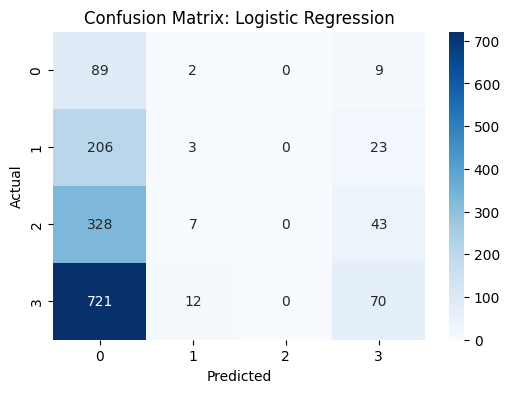

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


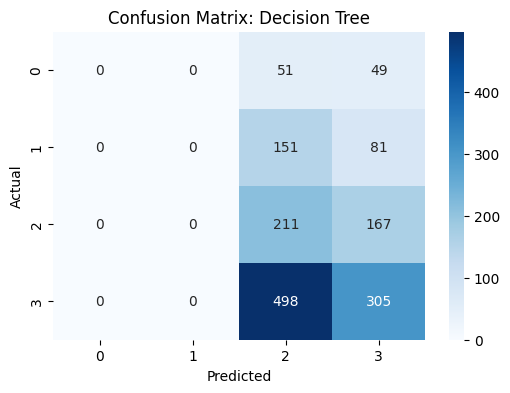

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


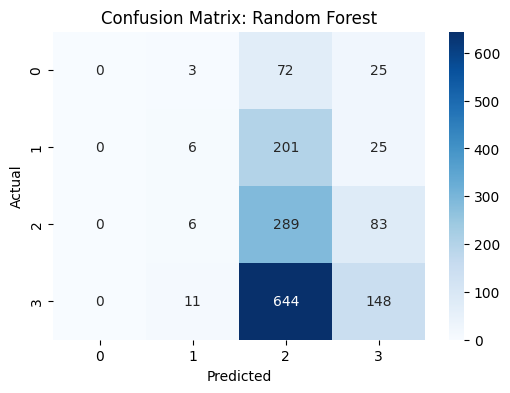

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


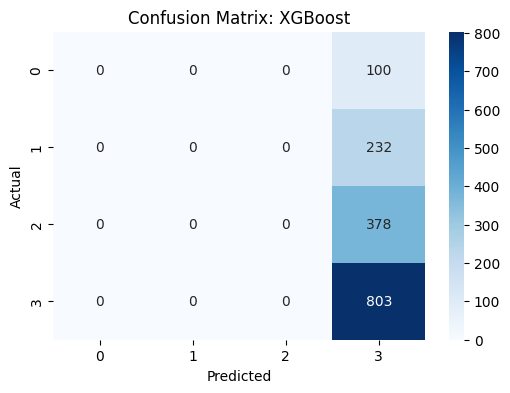

                 Model  Accuracy  F1 Score  Precision    Recall ROC AUC
0  Logistic Regression  0.107072  0.090120   0.279760  0.107072    None
1        Decision Tree  0.341044  0.312218   0.326758  0.341044    None
2        Random Forest  0.292796  0.243220   0.374787  0.292796    None
3              XGBoost  0.530734  0.368030   0.281678  0.530734    None


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Fit the models and calculate metrics on the test set
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(x_test)
    
    # Check if the model has predict_proba method (for probabilistic classifiers)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)
        if y_proba.shape[1] == 2:  # Binary classification case: select the probability of the positive class
            y_proba = y_proba[:, 1]
        else:  # If not binary, raise an error or handle appropriately
            y_proba = y_proba.max(axis=1)
    else:
        # If the model doesn't have predict_proba, use decision_function or handle accordingly
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_test)
        else:
            y_proba = y_train_encoded  # Use predictions directly if probabilities are unavailable
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    
    # For ROC AUC, ensure binary classification
    if len(set(y_test_encoded)) == 2:
        roc_auc = roc_auc_score(y_test_encoded, y_proba)
    else:
        roc_auc = None  # Handle multiclass or raise a warning

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc
    })
    
    # Plot ROC-AUC curve if binary classification
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC-AUC curve (for binary classification)
if roc_auc is not None:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='best')
    plt.show()

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

In [79]:
x_val = add_country_card_success_rate(X_val)
x_val = categorize_amount(x_val)
x_val = datetime_features(x_val)
x_val = add_country_psp_success_rate(x_val)

In [80]:
x_val.shape

(13610, 25)

In [81]:
categorical_cols = x_val.select_dtypes(include=['object']).columns
for col in categorical_cols:
    x_val[col] = label_encoder.fit_transform(x_val[col]) 

In [82]:
x_val = x_val[X_train.columns]

In [83]:
y_val_encoded = label_encoder.fit_transform(y_val)

In [84]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with the training data and validation data
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

y_train_encoded_series = pd.Series(y_train_encoded)
y_val_encoded_series = pd.Series(y_val_encoded)

# Train the final model with the best parameters on the combined training and validation data
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(pd.concat([X_train, x_val]),pd.concat([y_train_encoded_series, y_val_encoded_series]))

# Evaluate the final model on the test set
y_test_pred = final_model.predict(x_test)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Score: 1.0
Test Accuracy: 0.25644415069398546


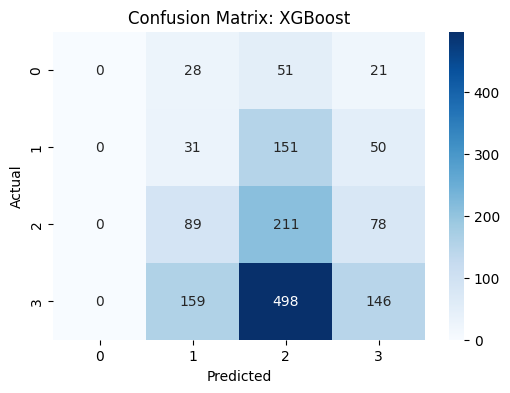

In [86]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall = recall_score(y_test_encoded, y_test_pred, average='weighted')

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
f1, precision, recall

(0.24057268441571464, 0.3360169229117781, 0.25644415069398546)

In [15]:
X_val.shape

(13610, 7)

In [16]:
X_val.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')

In [ ]:
# Define the new data point
new_data_point = pd.DataFrame({
    'tmsp': [pd.to_datetime('2019-03-01 12:00:00')],
    'country': ['Germany'],
    'amount': [150],
    'success': [1],  # Assuming success is known for the new data point
    'PSP': ['UK_Card'],
    '3D_secured': [0],
    'card': ['Visa']
})

# Apply the same feature engineering steps

# Calculate 'country_card_success_rate'
new_data_point = new_data_point.merge(success_rate, on=['country', 'card'], how='left')

# Calculate 'week_of_month'
new_data_point['week_of_month'] = new_data_point['tmsp'].apply(week_of_month)

# Extract 'hour'
new_data_point['hour'] = new_data_point['tmsp'].dt.hour

# Categorize 'transaction_hour'
new_data_point['transaction_hour'] = new_data_point['hour'].apply(categorize_hour)

# Categorize 'amount'
new_data_point['amount_category'] = new_data_point['amount'].apply(categorize_amount)

# Extract 'weekday'
new_data_point['weekday'] = new_data_point['tmsp'].dt.day_name()

# Calculate 'secured_success_rate_of_card'
new_data_point = new_data_point.merge(secured_success_rate, on=['country', 'card', '3D_secured'], how='left')

# Calculate 'country_psp_success_rate'
new_data_point = new_data_point.merge(country_psp_success_rate, on=['country', 'PSP'], how='left')

# Calculate specific PSP success rates for different countries
new_data_point['uk_card_germany_successrate'] = new_data_point.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'UK_Card' else 0, axis=1
)
new_data_point['uk_card_Austria_successrate'] = new_data_point.apply(
    lambda row: uk_card_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'UK_Card' else 0, axis=1
)
new_data_point['uk_card_swiz_successrate'] = new_data_point.apply(
    lambda row: uk_card_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'UK_Card' else 0, axis=1
)
new_data_point['simplecard_germany_successrate'] = new_data_point.apply(
    lambda row: simplecard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Simplecard' else 0, axis=1
)
new_data_point['simplecard_austria_successrate'] = new_data_point.apply(
    lambda row: simplecard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Simplecard' else 0, axis=1
)
new_data_point['simplecard_swiz_successrate'] = new_data_point.apply(
    lambda row: simplecard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Simplecard' else 0, axis=1
)
new_data_point['moneycard_germany_successrate'] = new_data_point.apply(
    lambda row: moneycard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Moneycard' else 0, axis=1
)
new_data_point['moneycard_Austria_successrate'] = new_data_point.apply(
    lambda row: moneycard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Moneycard' else 0, axis=1
)
new_data_point['moneycard_swiz_successrate'] = new_data_point.apply(
    lambda row: moneycard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Moneycard' else 0, axis=1
)
new_data_point['goldcard_germany_successrate'] = new_data_point.apply(
    lambda row: goldcard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Goldcard' else 0, axis=1
)
new_data_point['goldcard_Austria_successrate'] = new_data_point.apply(
    lambda row: goldcard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Goldcard' else 0, axis=1
)
new_data_point['goldcard_swiz_successrate'] = new_data_point.apply(
    lambda row: goldcard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Goldcard' else 0, axis=1
)

# Display the new data point with the mapped features
print(new_data_point)

,tmsp,country,amount,success,PSP,3D_secured,card,country_card_success_rate,week_of_month,hour,...,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate
0,2019-01-22 17:55:11,Austria,250,0,UK_Card,0,Visa,0.204069,4,17,...,0.197558,0.000000,0.199084,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,2019-02-23 02:46:55,Germany,208,0,UK_Card,0,Master,0.195348,4,2,...,0.199084,0.199084,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2019-02-08 08:55:57,Germany,149,0,Goldcard,0,Master,0.195348,2,8,...,0.396254,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.396254,0.0,0.0
3,2019-02-05 16:55:35,Switzerland,129,0,UK_Card,0,Diners,0.217274,2,16,...,0.193702,0.000000,0.000000,0.199084,0.000000,0.0,0.0,0.000000,0.0,0.0
4,2019-02-18 14:57:21,Germany,177,0,UK_Card,0,Master,0.195348,4,14,...,0.199084,0.199084,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35282,2019-01-12 12:51:23,Germany,195,1,Simplecard,0,Master,0.195348,2,12,...,0.166252,0.000000,0.000000,0.000000,0.166252,0.0,0.0,0.000000,0.0,0.0
35283,2019-02-21 15:10:36,Germany,172,0,Simplecard,0,Master,0.195348,4,15,...,0.166252,0.000000,0.000000,0.000000,0.166252,0.0,0.0,0.000000,0.0,0.0
35284,2019-02-13 09:42:53,Germany,88,1,UK_Card,0,Diners,0.226308,3,9,...,0.199084,0.199084,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
35285,2019-01-01 16:26:25,Switzerland,341,1,UK_Card,0,Visa,0.219988,1,16,...,0.193702,0.000000,0.000000,0.199084,0.000000,0.0,0.0,0.000000,0.0,0.0
